In [1]:
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import pandas as pd
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
adata = sc.read("PBMC.merged.h5ad")
adata.obs['louvain'] = None
adata.uns['neighbors']['connectivities'] = None
adata.uns['neighbors']['distances'] = None

In [3]:
def pca(adata):
    #calculate pca
    pca = PCA(n_components=50)
    result_pca = pca.fit_transform(adata.X)
    result_pca = np.array(result_pca, dtype = np.float32)
    adata.obsm['X_pca'] = result_pca
    return result_pca

def get_distances(matrix):
    D = pairwise_distances(X=matrix, Y=matrix)
    return D

def get_neighbors(D,k):
    knn_indices = np.argsort(D, axis=1)[0:,1:k+1]
    knn_distances = np.sort(D, axis=1)[0:,1:k+1]
    return knn_indices, knn_distances

def get_umap_connectivities(knn_i, knn_d, k):
    knn_connectivities = sc.neighbors.compute_connectivities_umap(knn_i, knn_d, n_obs=15476,n_neighbors=k)
    connectivities = knn_connectivities[1]
    distances = knn_connectivities[0]
    return connectivities, distances

def knn(adata, k):
    result_pca = pca(adata)
    D = get_distances(result_pca)
    knn_indices, knn_distances = get_neighbors(D,k)
    connectivities, distances = get_umap_connectivities(knn_indices, knn_distances, k)
    #pass connectivities, distances to scanpy
    adata.uns['neighbors']['connectivities'] = connectivities
    adata.uns['neighbors']['distances'] = distances

def bbknn(adata, neighbors_within_batch):
    result_pca = pca(adata)
    batch_unique = list(set(adata.obs['batch']))  #['0','1']
    knn_distances = np.zeros((adata.shape[0],neighbors_within_batch*len(batch_unique)))
    knn_indices = np.copy(knn_distances).astype(int)

    for i in range(len(batch_unique)):
        #reference batch
        batch_id = batch_unique[i]   #get batch id for ref_batch
        bool_idx = adata.obs['batch'] == batch_id  #get booleen index for reference batch
        ref_batch_pca = result_pca[bool_idx]  #using booleen index to get pca data for reference batch
        ref_batch_idx = np.arange(adata.shape[0])[bool_idx] #create a booleen index for ref_batch to map back to pca matrix

        for j in range(len(batch_unique)):
            #querry batch
            batch_id = batch_unique[j] #get batch id for query_batch
            bool_idx = adata.obs['batch'] == batch_id  #get booleen index for query batch
            query_batch_pca = result_pca[bool_idx]  #using booleen index to get pca data for query batch
            query_batch_idx = np.arange(adata.shape[0])[bool_idx]  #create a booleen index for query_batch to map back to pca matrix

            D = pairwise_distances(X=query_batch_pca, Y=ref_batch_pca)  #calculate pairwise_distances between query batch and ref_batch

            #sort distances and neighbors
            neighbors = np.argsort(D, axis=1)[0:,0:neighbors_within_batch]  #get indices for n nearest neighbors
            sorted_D = np.sort(D, axis=1)[0:,0:neighbors_within_batch]  #get distance for n nearest neighbors

            for n in range(neighbors.shape[0]):
                for k in range(neighbors.shape[1]):
                    temp_neighbor = neighbors[n,k]
                    neighbors[n,k] = ref_batch_idx[temp_neighbor]  #map n nearest neighbors to pca indices

            col_range = np.arange(i*neighbors_within_batch, (i+1)*neighbors_within_batch)
            knn_indices[query_batch_idx[:,None], col_range[None,:]] = neighbors
            knn_distances[query_batch_idx[:,None], col_range[None,:]] = sorted_D

    return knn_indices, knn_distances

def l_k_bbknn(adata, batch_unique, neighbors_within_batch,l):

    #this method makes an l subsampling of the bbknn computed in the graph() method
    # if k=4, meaning you are finding 4 neighbors between batches, and l=2:
    ## subsample 2 neighbors from batch1 and 2 neighbors from batch2

    result_pca = pca(adata)
    knn_indices, knn_distances = bbknn(adata, neighbors_within_batch)

    if l >= neighbors_within_batch:
        raise ValueError('l cannot be equal or larger than k')
    #initiate lk_bbknn l_bbknn_indices and l_bbknn_distances matrix
    l_bbknn_indices = np.zeros((knn_indices.shape[0], len(batch_unique)*l)).astype(int)
    l_bbknn_distances = np.zeros((knn_distances.shape[0], len(batch_unique)*l))

    for i in range(len(batch_unique)):

        batch_id = batch_unique[i]  #get batch id for ref_batch
        bool_idx = adata.obs['batch'] == batch_id  #get booleen index for reference batch
        ref_batch_pca = result_pca[bool_idx]  #using booleen index to get pca data for reference batch
        ref_batch_idx = np.arange(adata.shape[0])[bool_idx]  #create a booleen index for ref_batch to map back to pca matrix

        for j in range(len(batch_unique)):
            batch_id = batch_unique[j]   #get batch id for query_batch
            bool_idx = adata.obs['batch'] == batch_id  #get booleen index for query batch
            query_batch_pca = result_pca[bool_idx]  #using booleen index to get pca data for query batch
            query_batch_idx = np.arange(adata.shape[0])[bool_idx]  #create a booleen index for query_batch to map back to pca matrix

            D = pairwise_distances(X=query_batch_pca, Y=ref_batch_pca)  #calculate pairwise_distances between query batch and ref_batch

            neighbors = np.argsort(D, axis=1)[0:,0:neighbors_within_batch]  #get indices for n nearest neighbors
            sorted_D = np.sort(D, axis=1)[0:,0:neighbors_within_batch]    #get distance for n nearest neighbors

            for n in range(neighbors.shape[0]):
                for k in range(neighbors.shape[1]):
                    temp_neighbor = neighbors[n,k]
                    neighbors[n,k]=ref_batch_idx[temp_neighbor]   #map n nearest neighbors to pca indices

            col_range = np.arange(i*l, (i+1)*l)
            random_sample = random.sample(range(0,neighbors_within_batch), l)  #create indices for random sampling l from k
            #pass random sampled l nearest neighbors to l_bbknn_indices and distances matrix
            l_bbknn_indices[query_batch_idx[:,None], col_range[None,:]]= neighbors[:,random_sample]
            l_bbknn_distances[query_batch_idx[:,None], col_range[None,:]] = sorted_D[:,random_sample]

    return l_bbknn_indices, l_bbknn_distances

In [4]:
neighbors_within_batch=6
l=3
batch_unique=['0', '1']

In [5]:
bb6nn_indices, bb6nn_distances = bbknn(adata, neighbors_within_batch)
bb6nn_connectivities = sc.neighbors.compute_connectivities_umap(bb6nn_indices, bb6nn_distances, n_obs=15476, n_neighbors=12)
adata.uns['neighbors']['connectivities'] = bb6nn_connectivities[1]
adata.uns['neighbors']['distances'] = bb6nn_connectivities[0]

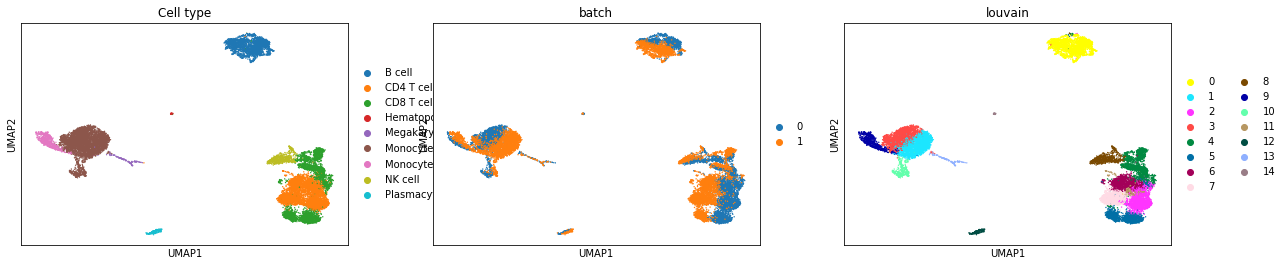

In [6]:
sc.tl.louvain(adata)
bb6nn_louvain = adata.obs['louvain']

sc.tl.umap(adata)
sc.pl.umap(adata, color=['Cell type', 'batch', 'louvain'])

In [10]:
adata.obs['louvain'] = None

bb3_6nn_indices, bb3_6nn_distances = l_k_bbknn(adata, batch_unique, neighbors_within_batch, l)
bb3_6nn_connectivities = sc.neighbors.compute_connectivities_umap(bb3_6nn_indices, bb3_6nn_distances, n_obs=15476,n_neighbors=2*l)
adata.uns['neighbors']['connectivities'] = bb3_6nn_connectivities[1]
adata.uns['neighbors']['distances'] = bb3_6nn_connectivities[0]

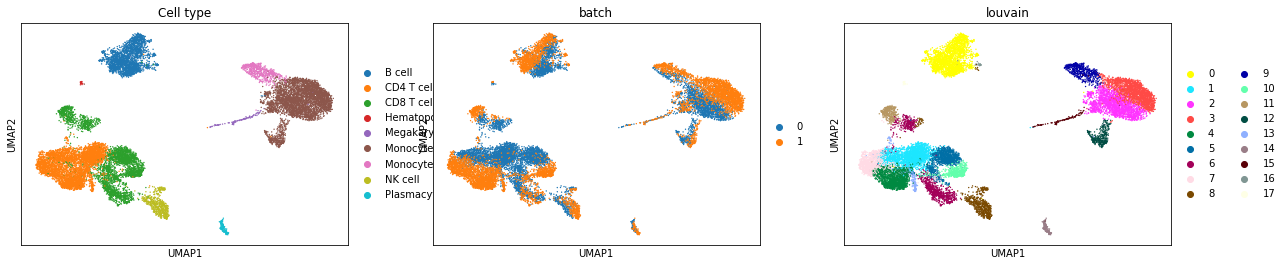

In [11]:
sc.tl.louvain(adata)
bb3_6nn_louvain = adata.obs['louvain']

sc.tl.umap(adata)
sc.pl.umap(adata,  color=['Cell type', 'batch','louvain'])

sample 1 finished
sample 2 finished
sample 3 finished
sample 4 finished
sample 5 finished
sample 6 finished
sample 7 finished
sample 8 finished
sample 9 finished
sample 10 finished
Average: 0.7861935472389273 SD: 0.04074700342466431


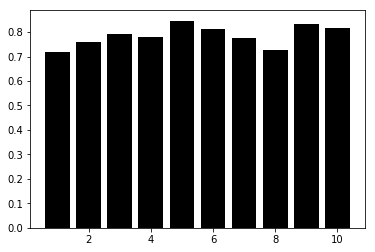

In [9]:
from sklearn.metrics.cluster import adjusted_rand_score

# number of samples to run
samples = 10

# list of ARIs obtained from each subsample
results = []

for sample in range(samples):
    adata.obs['louvain'] = None
    
    bb3_6nn_indices, bb3_6nn_distances = l_k_bbknn(adata, batch_unique, neighbors_within_batch, l)
    bb3_6nn_connectivities = sc.neighbors.compute_connectivities_umap(bb3_6nn_indices, bb3_6nn_distances, n_obs=15476,n_neighbors=2*l)
    adata.uns['neighbors']['connectivities'] = bb3_6nn_connectivities[1]
    adata.uns['neighbors']['distances'] = bb3_6nn_connectivities[0]
    
    sc.tl.louvain(adata)
    bb3_6nn_louvain = adata.obs['louvain']   
    
    ars = adjusted_rand_score(bb3_6nn_louvain, bb6nn_louvain)
    results.append(ars)
    
    print('sample', sample+1, 'finished')

# plot ARIs and print statistics
plt.bar(range(1, len(results)+1), results, color='black')
print('Average:', np.mean(results), 'SD:', np.std(results))